## 多项式回归

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

## 生成数据集

In [2]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# `labels`的维度: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    d2l.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-1.6547],
         [-0.2860]]),
 tensor([[ 1.0000e+00, -1.6547e+00,  1.3691e+00, -7.5515e-01,  3.1240e-01,
          -1.0339e-01,  2.8513e-02, -6.7402e-03,  1.3942e-03, -2.5633e-04,
           4.2416e-05, -6.3806e-06,  8.7986e-07, -1.1199e-07,  1.3237e-08,
          -1.4603e-09,  1.5102e-10, -1.4700e-11,  1.3514e-12, -1.1770e-13],
         [ 1.0000e+00, -2.8597e-01,  4.0889e-02, -3.8977e-03,  2.7866e-04,
          -1.5937e-05,  7.5960e-07, -3.1032e-08,  1.1093e-09, -3.5246e-11,
           1.0079e-12, -2.6204e-14,  6.2445e-16, -1.3736e-17,  2.8059e-19,
          -5.3493e-21,  9.5608e-23, -1.6083e-24,  2.5551e-26, -3.8457e-28]]),
 tensor([-5.8309,  4.4975]))

## 对模型进行训练和测试

In [4]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失。"""
    metric = d2l.Accumulator(2)  # 损失的总和, 样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [5]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式特征中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

## 三阶多项式函数拟合(正态)

weight: [[ 5.0013103  1.2206993 -3.4102433  5.522905 ]]


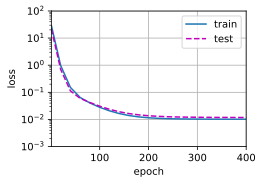

In [6]:
# 从多项式特征中选择前4个维度，即 1, x, x^2/2!, x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

## 线性函数拟合(欠拟合)

weight: [[3.315126 4.68971 ]]


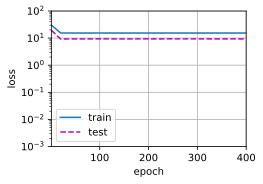

In [7]:
# 从多项式特征中选择前2个维度，即 1, x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

## 高阶多项式函数拟合(过拟合)

weight: [[ 4.98038673e+00  1.29214752e+00 -3.30855608e+00  5.19526052e+00
  -2.88059026e-01  6.34171724e-01  1.63231865e-01  1.04386702e-01
  -1.73211277e-01 -1.71924978e-01  1.16476454e-01 -3.90232913e-02
  -1.72008768e-01 -8.65156204e-02 -1.88326389e-02 -1.72234163e-01
  -5.84992990e-02 -6.13618530e-02  4.38183924e-04 -1.87940046e-01]]


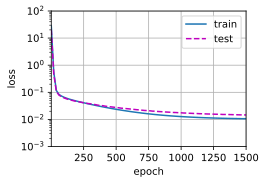

In [8]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)